In [1]:
from obspy.core import Stream, read
import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl 
import matplotlib.colors as colors
from matplotlib.colors import Normalize
import pandas as pd
import os 
import os.path

In [2]:
path_to_files = '/Users/sydneydybing/StrainProject/2024/'

earthquakes = pd.read_csv(path_to_files + 'M6_catalog_2004-2024.csv', dtype = str)

weird_events_only = False
if weird_events_only:
    earthquakes = earthquakes.iloc[[4,15]]

small_test = False
if small_test:
    earthquakes = earthquakes[11:16]
    
one_at_a_time = False
if one_at_a_time:
#     earthquakes = earthquakes[:1]
    earthquakes = earthquakes.iloc[[27]]

origin_times = earthquakes.time.values
mags = earthquakes.mag.values

bsm_mda = pd.read_csv(path_to_files + 'bsm_metadata.csv')
NA_only = bsm_mda.loc[bsm_mda['LONG'] < -110]
stas = NA_only['BNUM'].values

eqs_test = earthquakes[4:5]
ots_test = origin_times[4:5]
mags_test = mags[4:5]
rows_for_extra_times = [8,9,14,16]

dist_array = np.load(path_to_files + 'NA_evt-sta_dist_array_less500km_withdata_withrmssnrs_3COMP_newdetrend.npy')

# Array order:

# 0. Earthquake identifier
# 1. Earthquake origin time
# 2. Earthquake latitude
# 3. Earthquake longitude
# 4. Earthquake magnitude
# 5. Station name
# 6. Station latitude
# 7. Station longitude
# 8. Hypocentral distance (km)
# 9. RMS strain SNR

high_xlim_sec = 60

### Plot by event (rainbow for hypdist)

In [3]:
cmap = plt.get_cmap('turbo', 500) 

for idx in range(len(earthquakes)):
    
#     print(idx)
    
    no_data = False
    
    if idx >= 31: # No data available for 4 earliest earthquakes
        no_data = True
        
    if no_data == False:
        fig = plt.figure(figsize = (10,6), dpi = 300, facecolor = 'white', num = 1, clear = True)
        ax = fig.add_subplot(111)
        
    ot = origin_times[idx]
    print('Earthquake ' + str(idx+1) + '/' + str(len(mags)))
    
    if idx in rows_for_extra_times:
        cut_ot = ot[:13]
    else:
        cut_ot = ot[:10]
    
    eq_id = str(cut_ot) + '_M' + str(mags[idx])
#     print(eq_id)
        
    # Find rows that match this event in the array with the hypocentral distances
    
    i = np.where(dist_array[:,0] == eq_id)[0]
#     print(dist_array[i])
    
    snrs = []
    
    for sta in stas:
        
        try:
            
            # Find row that matches this station within the rows of the right event
            j = np.where(dist_array[i,5] == sta)[0]
            hypdist = float(dist_array[i][j][0][8])
            int_hypdist = int(hypdist)
            snr = float(dist_array[i][j][0][9])
            snrs.append(snr)
        
            # Peak strain data - only has the ones with SNR > 2
            pst = read(path_to_files + 'strain_data/3comp_peak_post_p_newdetrend/' + str(eq_id) + '/' + str(sta) + '.mseed')
                
        except:
            continue # skips to next station
        
        if snr >= 2: # Can use to limit by SNR further

            pst_times = pst[0].times()
            pst_data = pst[0].data
            log10_data = np.log10(pst_data)
            samp_rate = pst[0].stats.sampling_rate

            low_xlim_sec = 8
            high_xlim_sec = high_xlim_sec

            low_xlim_samp = int(low_xlim_sec * samp_rate)
            high_xlim_samp = int(high_xlim_sec * samp_rate)

            # Move the flat line at the beginning of each timeseries to the same level

            norm_data = np.copy(pst_data)
            norm_level = pst_data[0]
    #         print(norm_level)
            norm_data = norm_data - norm_level + 1*10**-9 # Subtract the starting value, add 10^-9 to set at 10^0 on nanostrain plot

            # Plot stations, but avoid plotting the weird stations for the two problem earthquakes

            if idx == 4 and sta == 'B072' or sta == 'B076':
                print('Skipping ' + str(cut_ot) + ' ' + str(sta))

            elif idx == 15 and sta == 'B928':
                print('Skipping ' + str(cut_ot) + ' ' + str(sta))

            else:
    #             ax.plot(pst_times, pst_data*10**9, color = cmap(int_hypdist-1), label = sta)
                ax.plot(pst_times[low_xlim_samp:high_xlim_samp], norm_data[low_xlim_samp:high_xlim_samp], color = cmap(int_hypdist-1), label = sta)
                # ax.plot(pst_times[low_xlim_samp:high_xlim_samp], pst_data[low_xlim_samp:high_xlim_samp], color = cmap(int_hypdist-1), label = sta)
                ax.set_yscale('log')
                ax.set_ylabel('Log of relative peak\nextensional strain', fontsize = 15)
                ax.set_xlabel('Time (s)', fontsize = 15)
                ax.set_xlim(low_xlim_sec,high_xlim_sec)
                if high_xlim_sec <= 30:
                    ax.axvline(x = 10, color = 'gray', linestyle = '--', alpha = 0.5)
                ax.tick_params(labelsize = 13)
        
        else:
            pass
        
#     print(snrs)
    q = np.where(np.array(snrs) >= 2)[0]
#     print(len(q))
            
    # Plot after each earthquake
    if no_data: 
        pass
    else:
        
        if len(q) == 0: # No waveforms with SNR >= 2
            ax.text(x = 0.3, y = 0.5, s = 'No waveforms with SNR >= 2', fontsize = 20)
            ax.set_title('Earthquake ' + str(cut_ot) + '_M' + str(mags[idx]), fontsize = 18)
#             plt.show();
        else:
            ax.set_title('Earthquake ' + str(cut_ot) + '_M' + str(mags[idx]), fontsize = 18)
            cbar = fig.colorbar(plt.cm.ScalarMappable(norm = Normalize(0, 500), cmap = cmap), ax = ax)
            cbar.ax.tick_params(labelsize = 11)
            cbar.ax.set_ylabel(ylabel = 'Hypocentral distance (km)', fontsize = 13)
            ax.legend(loc = 'lower right', ncol = 3, fontsize = 10)
            # plt.show();
        
        # Create folder for the event
        fig_save_dir = path_to_files + 'figures/3comp_peak_strain_plots_newdetrend/NA_M6_500km/leveled_at_p_arrival/by_event_cmap_hypdist/' + str(high_xlim_sec) + 's_limit/'
#         print(fig_save_dir)
        if os.path.isdir(fig_save_dir):
            pass
        else:
            os.makedirs(fig_save_dir)
        
        # plt.show()
        
        plt.savefig(fig_save_dir + str(eq_id) + '.png', format = 'PNG')
        plt.close();


Earthquake 1/35
Earthquake 2/35
Earthquake 3/35
Earthquake 4/35
Earthquake 5/35
Earthquake 6/35
Earthquake 7/35
Earthquake 8/35
Earthquake 9/35
Earthquake 10/35
Earthquake 11/35
Earthquake 12/35
Skipping 2019-07-06 B076
Earthquake 13/35
Skipping 2019-07-04 B076
Earthquake 14/35
Earthquake 15/35
Earthquake 16/35
Earthquake 17/35
Earthquake 18/35
Earthquake 19/35
Earthquake 20/35
Skipping 2014-08-24 B076
Earthquake 21/35
Earthquake 22/35
Earthquake 23/35
Earthquake 24/35
Earthquake 25/35
Earthquake 26/35
Earthquake 27/35
Earthquake 28/35
Earthquake 29/35
Earthquake 30/35
Earthquake 31/35
Earthquake 32/35
Earthquake 33/35
Earthquake 34/35
Earthquake 35/35


### Plot by hypocentral distance (rainbow for magnitude)

In [4]:
# Plotting function

cmap = plt.get_cmap('turbo', 15)
mag_color_mapping = np.arange(6,7.5,0.1)
tolerance = 1e-10

def plot_pst(ax):
#     ax.set_title('Earthquake ' + str(cut_ot) + '_M' + str(mags[idx]), fontsize = 18)
    ax.plot(pst_times[low_xlim_samp:high_xlim_samp], norm_data[low_xlim_samp:high_xlim_samp], color = cmap(mag_color_idx), label = mag)
#     ax.plot(pst_times, pst_data*10**9, color = cmap(mag_color_idx), label = mag)
    ax.set_yscale('log')
#     ax.set_xscale('log')
    ax.set_xlabel('Time (s)', fontsize = 13)
    ax.set_xlim(low_xlim_sec,high_xlim_sec)
    if high_xlim_sec <= 30:
        ax.axvline(x = 10, color = 'gray', linestyle = '--', alpha = 0.5)
#     ax.set_ylim(5*10**-2,5*10**4)
#     ax.legend()
    ax.tick_params(axis = 'x', bottom = False, labelbottom = False)
    ax.tick_params(axis = 'y', labelsize = 12)

In [5]:
fig, ((a0, a1), (a2, a3), (a4, a5), (a6, a7), (a8, a9)) = plt.subplots(nrows = 5, ncols = 2, figsize = (16,18), dpi = 300, facecolor = 'white')
plt.suptitle('Peak strains by hypocentral distance (km)', fontsize = 20)

for idx in range(len(earthquakes)):
    
    if idx >= 31: # No data available for 4 earliest earthquakes
#         print('Skipping ' + str(cut_ot) + ': no data')
        continue
        
    ot = origin_times[idx]
#     print('Earthquake ' + str(idx+1) + '/' + str(len(mags)))
    
    mag = round(float(mags[idx]),1)
    mag_color_idx = np.where(np.abs(mag_color_mapping - mag) < tolerance)[0]
    
    if idx in rows_for_extra_times:
        cut_ot = ot[:13]
    else:
        cut_ot = ot[:10]
    
    eq_id = str(cut_ot) + '_M' + str(mags[idx])
#     print(eq_id)
        
    # Find rows that match this event in the array with the hypocentral distances
    
    i = np.where(dist_array[:,0] == eq_id)[0]
#     print(dist_array[i])
        
    for sta in stas:
        
        try:
            
            # Find row that matches this station within the rows of the right event
            j = np.where(dist_array[i,5] == sta)[0]
            hypdist = float(dist_array[i][j][0][8])
            int_hypdist = int(hypdist)
            snr = float(dist_array[i][j][0][9])

            # Peak strain data - only has the ones with SNR > 2
            pst = read(path_to_files + 'strain_data/3comp_peak_post_p_newdetrend/' + str(eq_id) + '/' + str(sta) + '.mseed')
                
        except:
            continue # skips to next station

        if snr >= 2: # Can use to limit by SNR further

            pst_times = pst[0].times()
            pst_data = pst[0].data
            samp_rate = pst[0].stats.sampling_rate

            low_xlim_sec = 8
            high_xlim_sec = high_xlim_sec

            low_xlim_samp = int(low_xlim_sec * samp_rate)
            high_xlim_samp = int(high_xlim_sec * samp_rate)

            # Move the flat line at the beginning of each timeseries to the same level

            norm_data = np.copy(pst_data)
            norm_level = pst_data[0]
    #         print(norm_level)
            norm_data = norm_data - norm_level + 1*10**-9 # Subtract the starting value, add 10^-9 to set at 10^0 on nanostrain plot

            # Plot stations, but avoid plotting the weird stations for the two problem earthquakes

            if idx == 4 and sta == 'B072' or sta == 'B076':
                print('Skipping ' + str(cut_ot) + ' ' + str(sta))

            elif idx == 15 and sta == 'B928':
                print('Skipping ' + str(cut_ot) + ' ' + str(sta))

            else:

                # Figure out which plot to put it on based on hypocentral distance
                
                xtext = 0.85*high_xlim_sec # Location of distance bin label
                ytext = 10**0

                if int_hypdist <= 50:
                    plot_pst(a0)
                    a0.text(x = xtext, y = ytext, s = '<= 50 km', fontsize = 15)

                elif 50 < int_hypdist <= 100:
                    plot_pst(a1)
                    a1.text(x = xtext, y = ytext, s = '50-100 km', fontsize = 15)

                elif 100 < int_hypdist <= 150:
                    plot_pst(a2)
                    a2.text(x = xtext, y = ytext, s = '100-150 km', fontsize = 15)

                elif 150 < int_hypdist <= 200: 
                    plot_pst(a3)
                    a3.text(x = xtext, y = ytext, s = '150-200 km', fontsize = 15)

                elif 200 < int_hypdist <= 250: 
                    plot_pst(a4)
                    a4.set_ylabel('Log of relative peak extensional strain', fontsize = 15)
                    a4.text(x = xtext, y = ytext, s = '200-250 km', fontsize = 15)

                elif 250 < int_hypdist <= 300:  
                    plot_pst(a5)
                    a5.text(x = xtext, y = ytext, s = '250-300 km', fontsize = 15)

                elif 300 < int_hypdist <= 350: 
                    plot_pst(a6)
                    a6.text(x = xtext, y = ytext, s = '300-350 km', fontsize = 15)

                elif 350 < int_hypdist <= 400:
                    plot_pst(a7)
                    a7.text(x = xtext, y = ytext, s = '350-400 km', fontsize = 15)

                elif 400 < int_hypdist <= 450:
                    plot_pst(a8)
                    a8.tick_params(axis = 'x', bottom = True, labelbottom = True, labelsize = 12)
                    a8.text(x = xtext, y = ytext, s = '400-450 km', fontsize = 15)

                elif 450 < int_hypdist <= 500:
                    plot_pst(a9)
                    a9.tick_params(axis = 'x', bottom = True, labelbottom = True, labelsize = 12)
                    a9.text(x = xtext, y = ytext, s = '450-500 km', fontsize = 15)

fig.subplots_adjust(hspace = 0, wspace = 0.1, bottom = 0.2)
cbar_ax = fig.add_axes([0.25, 0.1, 0.5, 0.025])
cbar = fig.colorbar(plt.cm.ScalarMappable(norm = Normalize(6, 7.5), cmap = cmap), ax = a0, cax = cbar_ax, orientation = 'horizontal')
cbar.ax.set_title('Magnitude', fontsize = 15)
cbar.ax.tick_params(labelsize = 15)

# Create folder for the event
fig_save_dir = path_to_files + 'figures/3comp_peak_strain_plots_newdetrend/NA_M6_500km/leveled_at_p_arrival/hypdist_bin_cmap_mag/'
# print(fig_save_dir)
if os.path.isdir(fig_save_dir):
    pass
else:
    os.makedirs(fig_save_dir)

fig_name = fig_save_dir + str(high_xlim_sec) + 's_limit.png'
# print(fig_name)

# plt.show();

plt.savefig(fig_name, format = 'PNG')
plt.close();

Skipping 2019-07-06 B076
Skipping 2019-07-04 B076
Skipping 2014-08-24 B076


## Colored by SNR

### Plot by event

0.573235595141
577.055838557
289


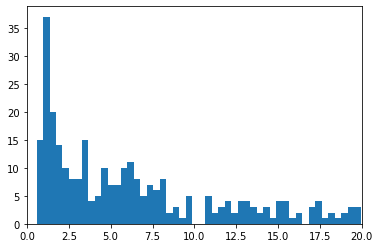

In [6]:
snrs = dist_array[:,9]
snrs_nonan = []

for snr in snrs:
#     print(snr)
    if snr != 'nan':
        snrs_nonan.append(float(snr))
        
print(min(snrs_nonan))
print(max(snrs_nonan))

max_snr = max(snrs_nonan)

lim = 20

m = np.where(np.array(snrs_nonan) <= lim)[0]
print(len(m))

plt.hist(np.array(snrs_nonan)[m], bins = 50)
plt.xlim(0, lim);

In [7]:
# Change depending on SNR limits of plots

low_snr = 2
high_snr = 100

num_colors = high_snr - low_snr

cmap = plt.get_cmap('Blues', num_colors)
snr_color_mapping = np.arange(low_snr, high_snr+1, 1)
tolerance = 1e-10

In [8]:
for idx in range(len(earthquakes)):
    
#     print(idx)
    
    no_data = False
    
    if idx >= 31: # No data available for 4 earliest earthquakes
        no_data = True
        
    if no_data == False:
        fig = plt.figure(figsize = (10,6), dpi = 300, facecolor = 'white', num = 1, clear = True)
        ax = fig.add_subplot(111)
        
    ot = origin_times[idx]
    print('Earthquake ' + str(idx+1) + '/' + str(len(mags)))
    
    if idx in rows_for_extra_times:
        cut_ot = ot[:13]
    else:
        cut_ot = ot[:10]
    
    eq_id = str(cut_ot) + '_M' + str(mags[idx])
#     print(eq_id)
        
    # Find rows that match this event in the array with the hypocentral distances
    
    i = np.where(dist_array[:,0] == eq_id)[0]
#     print(dist_array[i])
    
    snrs = []
    
    for sta in stas:
        
        try:
            
            # Find row that matches this station within the rows of the right event
            j = np.where(dist_array[i,5] == sta)[0]
            hypdist = float(dist_array[i][j][0][8])
            int_hypdist = int(hypdist)
            snr = int(float(dist_array[i][j][0][9]))
            snrs.append(snr)
        
            # Peak strain data - only has the ones with SNR > 2
            pst = read(path_to_files + 'strain_data/3comp_peak_post_p_newdetrend/' + str(eq_id) + '/' + str(sta) + '.mseed')
                
        except:
            continue # skips to next station
        
        if low_snr <= snr <= high_snr: # Can use to limit by SNR further

            snr_color_idx = np.where(np.abs(snr_color_mapping - snr) < tolerance)[0]
            color = cmap(snr_color_idx)
        
        else:
            color = 'red'
            
        pst_times = pst[0].times()
        pst_data = pst[0].data
        samp_rate = pst[0].stats.sampling_rate

        low_xlim_sec = 8
        high_xlim_sec = high_xlim_sec

        low_xlim_samp = int(low_xlim_sec * samp_rate)
        high_xlim_samp = int(high_xlim_sec * samp_rate)

        # Move the flat line at the beginning of each timeseries to the same level

        norm_data = np.copy(pst_data)
        norm_level = pst_data[0]
#         print(norm_level)
        norm_data = norm_data - norm_level + 1*10**-9 # Subtract the starting value, add 10^-9 to set at 10^0 on nanostrain plot

        # Plot stations, but avoid plotting the weird stations for the two problem earthquakes

        if idx == 4 and sta == 'B072' or sta == 'B076':
            print('Skipping ' + str(cut_ot) + ' ' + str(sta))

        elif idx == 15 and sta == 'B928':
            print('Skipping ' + str(cut_ot) + ' ' + str(sta))

        else:
#             ax.plot(pst_times, pst_data*10**9, color = cmap(int_hypdist-1), label = sta)
            ax.set_facecolor('lightgray')
            ax.plot(pst_times[low_xlim_samp:high_xlim_samp], norm_data[low_xlim_samp:high_xlim_samp], color = color, label = str(sta) + ', ' + str(snr))
            ax.set_yscale('log')
            ax.set_ylabel('Log of relative peak\nextensional strain', fontsize = 15)
            ax.set_xlabel('Time (s)', fontsize = 15)
            ax.set_xlim(low_xlim_sec,high_xlim_sec)
            if high_xlim_sec <= 30:
                ax.axvline(x = 10, color = 'gray', linestyle = '--', alpha = 0.5)
            ax.tick_params(labelsize = 13)
        
#     print(snrs)
    q = np.where(np.array(snrs) >= 2)[0]
#     print(len(q))
            
    # Plot after each earthquake
    if no_data: 
        pass
    else:
        
        if len(q) == 0: # No waveforms with SNR >= 2
            ax.text(x = 0.3, y = 0.5, s = 'No waveforms with SNR >= 2', fontsize = 20)
            ax.set_title('Earthquake ' + str(cut_ot) + '_M' + str(mags[idx]), fontsize = 18)
#             plt.show();
        else:
            ax.set_title('Earthquake ' + str(cut_ot) + '_M' + str(mags[idx]), fontsize = 18)
            cbar = fig.colorbar(plt.cm.ScalarMappable(norm = Normalize(low_snr, high_snr), cmap = cmap), ax = ax)
#             cbar = fig.colorbar(plt.cm.ScalarMappable(norm = colors.PowerNorm(gamma = 0.5, vmin = 0, vmax = max_snr), cmap = cmap), ax = ax)
            cbar.ax.tick_params(labelsize = 11)
            cbar.ax.set_ylabel(ylabel = 'SNR', fontsize = 13)
            ax.legend(loc = 'lower right', ncol = 3, fontsize = 10)
#             plt.show();
        
        # Create folder for the event
        fig_save_dir = path_to_files + 'figures/3comp_peak_strain_plots_newdetrend/NA_M6_500km/leveled_at_p_arrival/by_event_cmap_snr/' + str(high_xlim_sec) + 's_limit/'
#         print(fig_save_dir)
        if os.path.isdir(fig_save_dir):
            pass
        else:
            os.makedirs(fig_save_dir)

        plt.savefig(fig_save_dir + str(eq_id) + '.png', format = 'PNG')
        plt.close();


Earthquake 1/35
Earthquake 2/35
Earthquake 3/35
Earthquake 4/35
Earthquake 5/35
Earthquake 6/35
Earthquake 7/35
Earthquake 8/35
Earthquake 9/35
Earthquake 10/35
Earthquake 11/35
Earthquake 12/35
Skipping 2019-07-06 B076
Earthquake 13/35
Skipping 2019-07-04 B076
Earthquake 14/35
Earthquake 15/35
Earthquake 16/35
Earthquake 17/35
Earthquake 18/35
Earthquake 19/35
Earthquake 20/35
Skipping 2014-08-24 B076
Earthquake 21/35
Earthquake 22/35
Earthquake 23/35
Earthquake 24/35
Earthquake 25/35
Earthquake 26/35
Earthquake 27/35
Earthquake 28/35
Earthquake 29/35
Earthquake 30/35
Earthquake 31/35
Earthquake 32/35
Earthquake 33/35
Earthquake 34/35
Earthquake 35/35


### Hypdist bins

In [9]:
# Change depending on SNR limits of plots

low_snr = 2
high_snr = 100

num_colors = high_snr - low_snr

cmap = plt.get_cmap('Blues', num_colors)
snr_color_mapping = np.arange(low_snr, high_snr+1, 1)
tolerance = 1e-10

def plot_pst(ax):
#     ax.set_title('Earthquake ' + str(cut_ot) + '_M' + str(mags[idx]), fontsize = 18)
    ax.set_facecolor('lightgray')
    ax.plot(pst_times[low_xlim_samp:high_xlim_samp], norm_data[low_xlim_samp:high_xlim_samp], color = color, label = mag)
#     ax.plot(pst_times, pst_data*10**9, color = cmap(mag_color_idx), label = mag)
    ax.set_yscale('log')
#     ax.set_xscale('log')
    ax.set_xlabel('Time (s)', fontsize = 13)
    ax.set_xlim(low_xlim_sec,high_xlim_sec)
    if high_xlim_sec <= 30:
        ax.axvline(x = 10, color = 'gray', linestyle = '--', alpha = 0.5)
#     ax.set_ylim(5*10**-2,5*10**4)
#     ax.legend()
    ax.tick_params(axis = 'x', bottom = False, labelbottom = False)
    ax.tick_params(axis = 'y', labelsize = 12)

In [10]:
fig, ((a0, a1), (a2, a3), (a4, a5), (a6, a7), (a8, a9)) = plt.subplots(nrows = 5, ncols = 2, figsize = (16,18), dpi = 300, facecolor = 'white')
plt.suptitle('Peak strains by hypocentral distance (km)', fontsize = 20)

for idx in range(len(earthquakes)):
    
    if idx >= 31: # No data available for 4 earliest earthquakes
#         print('Skipping ' + str(cut_ot) + ': no data')
        continue
        
    ot = origin_times[idx]
#     print('Earthquake ' + str(idx+1) + '/' + str(len(mags)))
    
    if idx in rows_for_extra_times:
        cut_ot = ot[:13]
    else:
        cut_ot = ot[:10]
    
    eq_id = str(cut_ot) + '_M' + str(mags[idx])
#     print(eq_id)
        
    # Find rows that match this event in the array with the hypocentral distances
    
    i = np.where(dist_array[:,0] == eq_id)[0]
#     print(dist_array[i])
        
    for sta in stas:
        
        try:
            
            # Find row that matches this station within the rows of the right event
            j = np.where(dist_array[i,5] == sta)[0]
            hypdist = float(dist_array[i][j][0][8])
            int_hypdist = int(hypdist)
            snr = int(float(dist_array[i][j][0][9]))

            # Peak strain data - only has the ones with SNR > 2
            pst = read(path_to_files + 'strain_data/3comp_peak_post_p_newdetrend/' + str(eq_id) + '/' + str(sta) + '.mseed')
                
        except:
            continue # skips to next station

        if low_snr <= snr <= high_snr: # Can use to limit by SNR further

            snr_color_idx = np.where(np.abs(snr_color_mapping - snr) < tolerance)[0]
            color = cmap(snr_color_idx)
            
        else:
            color = 'red'

        pst_times = pst[0].times()
        pst_data = pst[0].data
        samp_rate = pst[0].stats.sampling_rate

        low_xlim_sec = 8
        high_xlim_sec = high_xlim_sec

        low_xlim_samp = int(low_xlim_sec * samp_rate)
        high_xlim_samp = int(high_xlim_sec * samp_rate)

        # Move the flat line at the beginning of each timeseries to the same level

        norm_data = np.copy(pst_data)
        norm_level = pst_data[0]
#         print(norm_level)
        norm_data = norm_data - norm_level + 1*10**-9 # Subtract the starting value, add 10^-9 to set at 10^0 on nanostrain plot

        # Plot stations, but avoid plotting the weird stations for the two problem earthquakes

        if idx == 4 and sta == 'B072' or sta == 'B076':
            print('Skipping ' + str(cut_ot) + ' ' + str(sta))

        elif idx == 15 and sta == 'B928':
            print('Skipping ' + str(cut_ot) + ' ' + str(sta))

        else:

            # Figure out which plot to put it on based on hypocentral distance

            xtext = 0.85*high_xlim_sec # Location of distance bin label
            ytext = 10**0

            if int_hypdist <= 50:
                plot_pst(a0)
                a0.text(x = xtext, y = ytext, s = '<= 50 km', fontsize = 15)

            elif 50 < int_hypdist <= 100:
                plot_pst(a1)
                a1.text(x = xtext, y = ytext, s = '50-100 km', fontsize = 15)

            elif 100 < int_hypdist <= 150:
                plot_pst(a2)
                a2.text(x = xtext, y = ytext, s = '100-150 km', fontsize = 15)

            elif 150 < int_hypdist <= 200: 
                plot_pst(a3)
                a3.text(x = xtext, y = ytext, s = '150-200 km', fontsize = 15)

            elif 200 < int_hypdist <= 250: 
                plot_pst(a4)
                a4.set_ylabel('Log of relative peak extensional strain', fontsize = 15)
                a4.text(x = xtext, y = ytext, s = '200-250 km', fontsize = 15)

            elif 250 < int_hypdist <= 300:  
                plot_pst(a5)
                a5.text(x = xtext, y = ytext, s = '250-300 km', fontsize = 15)

            elif 300 < int_hypdist <= 350: 
                plot_pst(a6)
                a6.text(x = xtext, y = ytext, s = '300-350 km', fontsize = 15)

            elif 350 < int_hypdist <= 400:
                plot_pst(a7)
                a7.text(x = xtext, y = ytext, s = '350-400 km', fontsize = 15)

            elif 400 < int_hypdist <= 450:
                plot_pst(a8)
                a8.tick_params(axis = 'x', bottom = True, labelbottom = True, labelsize = 12)
                a8.text(x = xtext, y = ytext, s = '400-450 km', fontsize = 15)

            elif 450 < int_hypdist <= 500:
                plot_pst(a9)
                a9.tick_params(axis = 'x', bottom = True, labelbottom = True, labelsize = 12)
                a9.text(x = xtext, y = ytext, s = '450-500 km', fontsize = 15)

fig.subplots_adjust(hspace = 0, wspace = 0.1, bottom = 0.2)
cbar_ax = fig.add_axes([0.25, 0.1, 0.5, 0.025])
cbar = fig.colorbar(plt.cm.ScalarMappable(norm = Normalize(low_snr, high_snr), cmap = cmap), ax = a0, cax = cbar_ax, orientation = 'horizontal')
cbar.ax.set_title('SNR', fontsize = 15)
cbar.ax.tick_params(labelsize = 15)

# Create folder for the event
fig_save_dir = path_to_files + 'figures/3comp_peak_strain_plots_newdetrend/NA_M6_500km/leveled_at_p_arrival/hypdist_bin_cmap_snr/'
# print(fig_save_dir)
if os.path.isdir(fig_save_dir):
    pass
else:
    os.makedirs(fig_save_dir)

fig_name = fig_save_dir + str(high_xlim_sec) + 's_limit.png'
# print(fig_name)

# plt.show();

plt.savefig(fig_name, format = 'PNG')
plt.close();

Skipping 2019-07-06 B076
Skipping 2019-07-04 B076
Skipping 2014-08-24 B076


# Plot by event but different station colors

In [11]:
dist_array[-12:]

array([['2008-01-10_M6.3', '2008-01-10T01:37:19.000Z', '43.785',
        '-127.264', '6.3', 'B017', '46.996', '-123.5575', '459.888509303',
        '0.847089892441'],
       ['2008-01-10_M6.3', '2008-01-10T01:37:19.000Z', '43.785',
        '-127.264', '6.3', 'B018', '46.9795', '-123.0203', '486.185774542',
        'nan'],
       ['2008-01-10_M6.3', '2008-01-10T01:37:19.000Z', '43.785',
        '-127.264', '6.3', 'B022', '45.95461', '-123.93105',
        '357.019087994', 'nan'],
       ['2008-01-10_M6.3', '2008-01-10T01:37:19.000Z', '43.785',
        '-127.264', '6.3', 'B026', '45.30935', '-123.82305',
        '321.608845577', '1.26947440015'],
       ['2008-01-10_M6.3', '2008-01-10T01:37:19.000Z', '43.785',
        '-127.264', '6.3', 'B027', '44.49733', '-122.96217',
        '353.150724443', 'nan'],
       ['2008-01-10_M6.3', '2008-01-10T01:37:19.000Z', '43.785',
        '-127.264', '6.3', 'B028', '44.49367', '-122.96383',
        '352.940808323', 'nan'],
       ['2008-01-10_M6.3', '20

In [12]:
for idx in range(len(earthquakes)):
    
#     print(idx)
    
    no_data = False
    
    if idx >= 31: # No data available for 4 earliest earthquakes
        no_data = True
        
    if no_data == False:
        fig = plt.figure(figsize = (10,6), dpi = 300, facecolor = 'white', num = 1, clear = True)
        ax = fig.add_subplot(111)
        
    ot = origin_times[idx]
    print('Earthquake ' + str(idx+1) + '/' + str(len(mags)))
    
    if idx in rows_for_extra_times:
        cut_ot = ot[:13]
    else:
        cut_ot = ot[:10]
    
    eq_id = str(cut_ot) + '_M' + str(mags[idx])
#     print(eq_id)
        
    # Find rows that match this event in the array with the hypocentral distances
    
    i = np.where(dist_array[:,0] == eq_id)[0]
#     print(dist_array[i])
    
    snrs = []
    
    for sta in stas:
        
        try:
            
            # Find row that matches this station within the rows of the right event
            j = np.where(dist_array[i,5] == sta)[0]
            hypdist = float(dist_array[i][j][0][8])
            int_hypdist = int(hypdist)
            snr = float(dist_array[i][j][0][9])
            snrs.append(snr)
        
            # Peak strain data - only has the ones with SNR > 2
            pst = read(path_to_files + 'strain_data/3comp_peak_post_p_newdetrend/' + str(eq_id) + '/' + str(sta) + '.mseed')
                
        except:
            continue # skips to next station
        
        if snr >= 0: # Can use to limit by SNR further

            pst_times = pst[0].times()
            pst_data = pst[0].data
            log10_data = np.log10(pst_data)
            samp_rate = pst[0].stats.sampling_rate

            low_xlim_sec = 8
            high_xlim_sec = 60

            low_xlim_samp = int(low_xlim_sec * samp_rate)
            high_xlim_samp = int(high_xlim_sec * samp_rate)

            # Move the flat line at the beginning of each timeseries to the same level

            norm_data = np.copy(pst_data)
            norm_level = pst_data[0]
    #         print(norm_level)
            norm_data = norm_data - norm_level + 1*10**-9 # Subtract the starting value, add 10^-9 to set at 10^0 on nanostrain plot

            # Plot stations, but avoid plotting the weird stations for the two problem earthquakes

            if idx == 4 and sta == 'B072' or sta == 'B076':
                print('Skipping ' + str(cut_ot) + ' ' + str(sta))

            elif idx == 15 and sta == 'B928':
                print('Skipping ' + str(cut_ot) + ' ' + str(sta))

            else:
    #             ax.plot(pst_times, pst_data*10**9, color = cmap(int_hypdist-1), label = sta)
                ax.plot(pst_times[low_xlim_samp:high_xlim_samp], norm_data[low_xlim_samp:high_xlim_samp], label = sta)
                # ax.plot(pst_times[low_xlim_samp:high_xlim_samp], pst_data[low_xlim_samp:high_xlim_samp], color = cmap(int_hypdist-1), label = sta)
                ax.set_yscale('log')
                ax.set_ylabel('Log of relative peak\nextensional strain', fontsize = 15)
                ax.set_xlabel('Time (s)', fontsize = 15)
                ax.set_xlim(low_xlim_sec,high_xlim_sec)
                if high_xlim_sec <= 30:
                    ax.axvline(x = 10, color = 'gray', linestyle = '--', alpha = 0.5)
                ax.tick_params(labelsize = 13)
        
        else:
            pass
        
#     print(snrs)
    q = np.where(np.array(snrs) >= 2)[0]
#     print(len(q))
            
    # Plot after each earthquake
    if no_data: 
        pass
    else:
        
        ax.text(x = 0.3, y = 0.5, s = 'No waveforms with SNR >= 2', fontsize = 20)
        ax.set_title('Earthquake ' + str(cut_ot) + '_M' + str(mags[idx]), fontsize = 18)
#             plt.show();
        ax.set_title('Earthquake ' + str(cut_ot) + '_M' + str(mags[idx]), fontsize = 18)
        ax.legend(loc = 'lower right', ncol = 3, fontsize = 10)
        # plt.show();
        
        # Create folder for the event
        fig_save_dir = path_to_files + 'figures/3comp_peak_strain_plots_newdetrend/NA_M6_500km/leveled_at_p_arrival/by_event_indiv_sta_colors/' + str(high_xlim_sec) + 's_limit/'
#         print(fig_save_dir)
        if os.path.isdir(fig_save_dir):
            pass
        else:
            os.makedirs(fig_save_dir)
        
        # plt.show()
        
        plt.savefig(fig_save_dir + str(eq_id) + '.png', format = 'PNG')
        plt.close();


Earthquake 1/35
Earthquake 2/35
Earthquake 3/35
Earthquake 4/35
Earthquake 5/35
Earthquake 6/35
Earthquake 7/35
Earthquake 8/35
Earthquake 9/35
Earthquake 10/35
Earthquake 11/35
Earthquake 12/35
Skipping 2019-07-06 B076
Earthquake 13/35
Skipping 2019-07-04 B076
Earthquake 14/35


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


Earthquake 15/35
Earthquake 16/35
Earthquake 17/35
Earthquake 18/35
Earthquake 19/35
Earthquake 20/35
Skipping 2014-08-24 B076
Earthquake 21/35
Earthquake 22/35
Earthquake 23/35
Earthquake 24/35
Earthquake 25/35
Earthquake 26/35
Earthquake 27/35
Earthquake 28/35
Earthquake 29/35
Earthquake 30/35


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


Earthquake 31/35
Earthquake 32/35
Earthquake 33/35
Earthquake 34/35
Earthquake 35/35
